## Autores: Frederico Curti e Raphael Costa

# Encontro 13: Medidas de Centralidade

Importando a biblioteca:

In [1]:
%matplotlib inline
import sys
sys.path.append('..')

from random import choice
from itertools import permutations

import pandas as pd
import networkx as nx

from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import socnet as sn
import math

In [2]:
from scipy import stats as ss

Configurando a biblioteca:

In [3]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

Carregando rede de casamentos entre famílias de Florença durante a Renascença.

J. F. Padgett e C. K. Ansell. *Robust action and the rise of the Medici, 1400–1434.* American Journal of
Sociology 98, págs. 1259-1319, 1993.

In [4]:
g = sn.load_graph('Renaissance.gml', has_pos=True)

sn.show_graph(g, nlab=True)

Função que registra, em cada nó, seus sucessores em geodésicas de $s$ a $t$.

In [5]:
def set_geodesic_successors(g, s, t):
    for n in g.nodes:
        g.nodes[n]['geodesic_successors'] = set()

    for p in nx.all_shortest_paths(g, s, t):
        for i in range(len(p) - 1):
            g.nodes[p[i]]['geodesic_successors'].add(p[i + 1])

Funções que representam uma escolha aleatória de sucessor para diferentes tipos de trajetórias.

In [6]:
# Pense que o atributo 'passages' abaixo indica quantas
# vezes um fluxo já passou por um nó ou por uma aresta.

def random_geodesic_successor(g, n):
    return choice([m for m in g.nodes[n]['geodesic_successors']])

def random_path_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.nodes[m]['passages'] == 0])

def random_trail_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.edges[n, m]['passages'] == 0])

def random_walk_successor(g, n):
    return choice([m for m in g.neighbors(n)])

Função que faz uma simulação de fluxo de $s$ a $t$, que pode ou não ser bem-sucedida.

In [7]:
def simulate_single_flow(g, s, t, fn, transfer):
    # Inicializa o atributo 'passages' de cada nó.
    for n in g.nodes:
        g.nodes[n]['passages'] = 0
    g.nodes[s]['passages'] = 1

    # Inicializa o atributo 'passages' de cada aresta.
    for n, m in g.edges:
        g.edges[n, m]['passages'] = 0

    # Inicializa s como o único dono do insumo.
    for n in g.nodes:
        g.nodes[n]['owner'] = False
    g.nodes[s]['owner'] = True

    # Simula o fluxo, contando o número total de passos.

    steps = 0

    while True:
        # O conjunto reached representa todos os nós
        # que o fluxo consegue alcançar no passo atual.
        reached = set()

        # Verifica cada um dos donos atuais do insumo.

        owners = [n for n in g.nodes if g.nodes[n]['owner']]

        for n in owners:
            # Escolhe aleatoriamente um dos sucessores.
            try:
                m = fn(g, n)
            except IndexError:
                continue

            # Deixa de ser dono do insumo.
            g.nodes[n]['owner'] = not transfer

            # Incrementa o atributo 'passages' do nó.
            g.nodes[m]['passages'] += 1

            # Incrementa o atributo 'passages' da aresta.
            g.edges[n, m]['passages'] += 1

            # Registra que consegue alcançar esse nó.
            reached.add(m)

        # Todo nó alcançado passa a ser dono do insumo.

        for n in reached:
            g.nodes[n]['owner'] = True

        # Isso conclui o passo atual da simulação.
        steps += 1

        # Se o passo alcançou t, chegamos ao fim da simulação.
        # Ela foi bem-sucedida: devolvemos o número de passos.
        if t in reached:
            return steps

        # Se o passo não alcançou ninguém, chegamos ao fim da
        # simulação. Ela não foi bem-sucedida: devolvemos -1.
        if not reached:
            return -1

Função que faz simulações de fluxo de $s$ a $t$ até uma ser bem-sucedida.

In [8]:
def simulate_successful_flow(g, s, t, fn, transfer):
    if (fn == random_geodesic_successor):
        set_geodesic_successors(g, s, t)

    while True:
        steps = simulate_single_flow(g, s, t, fn, transfer)

        if steps != -1:
            return steps

Função que faz simulações de fluxo para todo $s$ e $t$ possíveis, e tira disso um *closeness simulado* e um *betweenness simulado*.

In [9]:
def simulate_all_flows(g, fn, transfer):
    for n in g.nodes:
        g.nodes[n]['closeness'] = 0
        g.nodes[n]['betweenness'] = 0

    for s, t in permutations(g.nodes, 2):
        steps = simulate_successful_flow(g, s, t, fn, transfer)

        g.nodes[s]['closeness'] += steps
        for n in g.nodes:
            if n != s and n != t:
                g.nodes[n]['betweenness'] += g.nodes[n]['passages']

    # Normalizações necessárias para comparar com os
    # resultados analíticos. Não é preciso entender.
    for n in g.nodes:
        g.nodes[n]['closeness'] = (g.number_of_nodes() - 1) / g.nodes[n]['closeness']
        g.nodes[n]['betweenness'] /= (g.number_of_nodes() - 1) * (g.number_of_nodes() - 2)

Média de *closeness simulado* e *betweenness simulado* para muitas repetições da simulação acima.

Cálculo de *closeness* e *betweenness* a partir das funções prontas da NetworkX, para comparação.

In [10]:
cc = nx.closeness_centrality(g)
bc = nx.betweenness_centrality(g)

Construção de data frame só para comparar mais facilmente.

In [11]:
TIMES = 100

functions = [random_geodesic_successor, random_path_successor, random_trail_successor, random_walk_successor]
isTransfer = [True, False]
dataframes = []

g = g.copy()
for fn in functions:
    for transfer in isTransfer:
        
        for n in g.nodes:
            g.nodes[n]['mean_closeness'] = 0
            g.nodes[n]['mean_betweenness'] = 0

        for _ in range(TIMES):
            simulate_all_flows(g, fn, transfer)

            for n in g.nodes:
                g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
                g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']

        for n in g.nodes:
            g.nodes[n]['mean_closeness'] /= TIMES
            g.nodes[n]['mean_betweenness'] /= TIMES
         
        dataframes.append(pd.DataFrame({
            'família': [g.nodes[n]['label'] for n in g.nodes],
            'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
            'closeness analítico': [cc[n] for n in g.nodes],
            'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
            'betweenness analítico': [bc[n] for n in g.nodes],
            'transfer' : [transfer for n in g.nodes],
            'function' : [fn.__name__ for n in g.nodes],
        }))

In [12]:
df = pd.DataFrame()
for d in dataframes:
    df = df.append(d)

In [15]:
# # Geodesica com transferencia True é o benchmark
# f = familias[0]

# statistics, pvalue = ss.ttest_ind(
#     df[df.família == 'castellan'].iloc[0]['closeness simulado'],
#     df[df.família == 'castellan'].iloc[1]['closeness simulado']
# )

In [14]:
g = sn.load_graph('Renaissance.gml', has_pos=True)
familias = df.família.drop_duplicates().values
data = {}

for f in range(len(familias)):
    data[familias[f]] = {
        'closeness': {},
        'betweenness': {}
    }    
    for fn in functions:
        for transfer in isTransfer:
            data[familias[f]]['betweenness'][f'{fn.__name__}_{transfer}'] = []
            data[familias[f]]['closeness'][f'{fn.__name__}_{transfer}'] = []

        

# print("Carregando familia ", familias[f])
#     ss.ttest_ind()
for fn in functions:
    for transfer in isTransfer:

        
        for _ in range(TIMES):
            simulate_all_flows(g, fn, transfer)

            for n in g.nodes:
                data[g.nodes[n]['label']]['betweenness'][f'{fn.__name__}_{transfer}'].append(g.nodes[n]['betweenness'])
                data[g.nodes[n]['label']]['closeness'][f'{fn.__name__}_{transfer}'].append(g.nodes[n]['closeness'])

#             for n in g.nodes:
#                 g.nodes[n]['mean_closeness'] /= TIMES
#                 g.nodes[n]['mean_betweenness'] /= TIMES

#             dataframes.append(pd.DataFrame({
#                 'família': [g.nodes[n]['label'] for n in g.nodes],
#                 'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
#                 'closeness analítico': [cc[n] for n in g.nodes],
#                 'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
#                 'betweenness analítico': [bc[n] for n in g.nodes],
#                 'transfer' : [transfer for n in g.nodes],
#                 'function' : [fn.__name__ for n in g.nodes],
#             }))
        print('finalizou ', fn.__name__,' transfer: ', transfer)


finalizou  random_geodesic_successor  transfer:  True
finalizou  random_geodesic_successor  transfer:  False
finalizou  random_path_successor  transfer:  True
finalizou  random_path_successor  transfer:  False
finalizou  random_trail_successor  transfer:  True
finalizou  random_trail_successor  transfer:  False
finalizou  random_walk_successor  transfer:  True
finalizou  random_walk_successor  transfer:  False


In [16]:
# data['albizzi']['betweenness']['random_geodesic_successor_False'][0:10]

t_results = pd.DataFrame({
    "familia": [],
    "centralidade": [],
    "funcao": [],
    "statistic": [],
    "pvalue": []
})

for family, param in data.items():
    benchmark_bet = param['betweenness']['random_geodesic_successor_True']
    benchmark_clos = param['closeness']['random_geodesic_successor_True']
    for k, v in param.items():
        for k2, v2 in v.items():
            nested_param = k
            if (k2 != 'random_geodesic_successor_True'):
                if (nested_param == 'betweenness'):
                    statistic, pvalue = ss.ttest_ind(benchmark_bet, v2)
                else:
                    statistic, pvalue = ss.ttest_ind(benchmark_clos, v2)
                    
                if np.isnan(statistic):
                    print("\n IS NAN!", benchmark_bet,'\n', v2, '\n')
                    
                t_results = t_results.append({
                    "familia": family,
                    "centralidade": nested_param,
                    "funcao": k2,
                    "statistic": statistic,
                    "pvalue": pvalue
                }, ignore_index=True)


 IS NAN! [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0


 IS NAN! [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

(array([ 2.,  1.,  5.,  6.,  9., 11., 17.,  0., 11.,  6., 10.,  0.,  8.,
         5.,  0.,  5.,  2.,  0.,  0.,  2.]),
 array([0.20588235, 0.20879578, 0.21170921, 0.21462264, 0.21753607,
        0.2204495 , 0.22336293, 0.22627636, 0.22918979, 0.23210322,
        0.23501665, 0.23793008, 0.24084351, 0.24375694, 0.24667037,
        0.2495838 , 0.25249723, 0.25541065, 0.25832408, 0.26123751,
        0.26415094]),
 <a list of 20 Patch objects>)

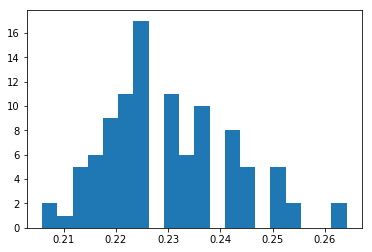

In [17]:
# print(np.mean(data['ginori']['betweenness']['random_geodesic_successor_True']))
plt.hist(data['ginori']['closeness']['random_path_successor_False'], bins=20)
# rvs1 = ss.norm.rvs(loc=5,scale=10,size=1500)
# plt.hist(rvs1)

In [18]:
t_results

familia centralidade                           funcao   statistic  \
0       ginori    closeness  random_geodesic_successor_False    0.000000   
1       ginori    closeness       random_path_successor_True   57.123777   
2       ginori    closeness      random_path_successor_False   84.271438   
3       ginori    closeness      random_trail_successor_True   48.030602   
4       ginori    closeness     random_trail_successor_False   80.142278   
5       ginori    closeness       random_walk_successor_True  223.911883   
6       ginori    closeness      random_walk_successor_False  114.834912   
7       ginori  betweenness  random_geodesic_successor_False         NaN   
8       ginori  betweenness       random_path_successor_True         NaN   
9       ginori  betweenness      random_path_successor_False -144.400398   
10      ginori  betweenness      random_trail_successor_True         NaN   
11      ginori  betweenness     random_trail_successor_False -150.407781   
12      ginori  betweenness       random_walk_successor_True  -60.241018   
13      ginori  betweenness      random_walk_successor_False  -84.263663   
14   lambertes    closeness  random_geodesic_successor_False    0.000000   
15   lambertes    closeness       random_path_successor_True   45.947507   
16   lambertes    closeness      random_path_successor_False   81.954162   
17   lambertes    closeness      random_trail_successor_True   41.446563   
18   lambertes    closeness     random_trail_successor_False   83.614983   
19   lambertes    closeness       random_walk_successor_True  216.066229   
20   lambertes    closeness      random_walk_successor_False  104.557600   
21   lambertes  betweenness  random_geodesic_successor_False         NaN   
22   lambertes  betweenness       random_path_successor_True         NaN   
23   lambertes  betweenness      random_path_successor_False -131.413454   
24   lambertes  betweenness      random_trail_successor_True         NaN   
25   lambertes  betweenness     random_trail_successor_False -139.808210   
26   lambertes  betweenness       random_walk_successor_True  -72.107430   
27   lambertes  betweenness      random_walk_successor_False -101.836065   
28     albizzi    closeness  random_geodesic_successor_False    0.000000   
29     albizzi    closeness       random_path_successor_True   54.510925   
..         ...          ...                              ...         ...   
180    peruzzi  betweenness       random_walk_successor_True  -63.153813   
181    peruzzi  betweenness      random_walk_successor_False -104.500458   
182  barbadori    closeness  random_geodesic_successor_False         NaN   
183  barbadori    closeness       random_path_successor_True   68.813459   
184  barbadori    closeness      random_path_successor_False   91.244921   
185  barbadori    closeness      random_trail_successor_True   46.285812   
186  barbadori    closeness     random_trail_successor_False   91.843530   
187  barbadori    closeness       random_walk_successor_True  375.570685   
188  barbadori    closeness      random_walk_successor_False  115.070430   
189  barbadori  betweenness  random_geodesic_successor_False -268.191841   
190  barbadori  betweenness       random_path_successor_True  -44.574109   
191  barbadori  betweenness      random_path_successor_False -174.253002   
192  barbadori  betweenness      random_trail_successor_True  -46.877146   
193  barbadori  betweenness     random_trail_successor_False -151.677320   
194  barbadori  betweenness       random_walk_successor_True  -83.509306   
195  barbadori  betweenness      random_walk_successor_False  -94.362847   
196  castellan    closeness  random_geodesic_successor_False    0.000000   
197  castellan    closeness       random_path_successor_True   53.865651   
198  castellan    closeness      random_path_successor_False   98.253863   
199  castellan    closeness      random_trail_successor_True   52.634603   
200  castellan    closeness     random_trail_successor_

E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

Um *feedback* da atividade sobre *coreness no Jazz* será dado em breve, para vocês terem uma melhor referência do item 2.

In [19]:
len(data['castellan']['betweenness']['random_path_successor_True'])

100

In [20]:
t = pd.DataFrame({
    "funcao": [],
    "transfer": [],
    "statistic_closeness": [],
    "pvalue_closeness": [],
    "statistic_betweenness": [],
    "pvalue_betweenness": []
})

benchmark_closeness = df[(df.function == 'random_geodesic_successor') & (df.transfer == True)]['closeness simulado']
benchmark_betweenness = df[(df.function == 'random_geodesic_successor') & (df.transfer == True)]['betweenness simulado']

for fn in functions:
    for transfer in isTransfer:
         if not (fn.__name__ == 'random_geodesic_successor' and transfer == True):
#             print(fn, transfer)
            t_closeness_statistic, t_closeness_pvalue = ss.ttest_ind(benchmark_closeness, df[(df.function == fn.__name__) & (df.transfer == transfer)]['closeness simulado'])
            t_betweenness_statistic, t_betweenness_pvalue = ss.ttest_ind(benchmark_betweenness, df[(df.function == fn.__name__) & (df.transfer == transfer)]['betweenness simulado'])

            t = t.append({
                "funcao": fn.__name__,
                "transfer": transfer,
                "statistic_closeness": t_closeness_statistic ,
                "pvalue_closeness": t_closeness_pvalue,
                "statistic_betweenness": t_betweenness_statistic,
                "pvalue_betweenness": t_betweenness_pvalue
            }, ignore_index=True )

In [21]:
t

funcao  transfer  statistic_closeness  pvalue_closeness  \
0  random_geodesic_successor       0.0             0.000000      1.000000e+00   
1      random_path_successor       1.0             8.206199      6.228718e-09   
2      random_path_successor       0.0             8.054335      9.039613e-09   
3     random_trail_successor       1.0             8.432259      3.597865e-09   
4     random_trail_successor       0.0             8.654802      2.109841e-09   
5      random_walk_successor       1.0            19.550114      7.361257e-18   
6      random_walk_successor       0.0            13.238063      1.419977e-13   

   statistic_betweenness  pvalue_betweenness  
0              -1.948729        6.141227e-02  
1              -2.186035        3.733451e-02  
2              -8.380624        4.075971e-09  
3              -2.132648        4.186019e-02  
4              -7.008488        1.271992e-07  
5              -6.411704        6.088902e-07  
6              -5.232360        1.469628e-05

**DICIONÁRIO NÚMERO-FAMÍLIA**

In [107]:
familias

0        ginori
1     lambertes
2       albizzi
3      guadagni
4         pazzi
5      salviati
6        medici
7     tornabuon
8      bischeri
9       ridolfi
10    acciaiuol
11      strozzi
12      peruzzi
13    barbadori
14    castellan
Name: família, dtype: object

**RANKING POR CLOSENESS**
<a id="r"></a>

In [22]:
closeness_rank = []
for fn in functions:
    for transfer in isTransfer:
        r = list(df[(df.function == fn.__name__) & (df.transfer == transfer)].sort_values(by='closeness simulado').index)
        closeness_rank.append(r)
        print(fn.__name__, transfer)
        print(r, '\n')

random_geodesic_successor True
[4, 1, 0, 12, 10, 5, 14, 8, 11, 13, 3, 2, 7, 9, 6] 

random_geodesic_successor False
[4, 1, 0, 12, 10, 5, 14, 8, 11, 13, 3, 2, 7, 9, 6] 

random_path_successor True
[4, 0, 1, 12, 11, 13, 10, 8, 5, 14, 9, 7, 2, 3, 6] 

random_path_successor False
[4, 5, 0, 1, 10, 12, 14, 2, 6, 13, 3, 11, 8, 9, 7] 

random_trail_successor True
[4, 1, 0, 10, 14, 11, 8, 12, 9, 5, 7, 3, 13, 2, 6] 

random_trail_successor False
[4, 5, 0, 1, 10, 12, 14, 2, 11, 8, 3, 6, 13, 9, 7] 

random_walk_successor True
[6, 12, 9, 8, 14, 3, 11, 7, 0, 2, 1, 10, 13, 5, 4] 

random_walk_successor False
[4, 1, 0, 12, 5, 10, 14, 8, 2, 11, 9, 3, 7, 13, 6] 



**RANKING POR BETWEENNESS**

In [106]:
betweenness_rank = []
for fn in functions:
    for transfer in isTransfer:
        r = list(df[(df.function == fn.__name__) & (df.transfer == transfer)].sort_values(by='betweenness simulado').index)
        print(fn.__name__, transfer)
        print(r, '\n')
        betweenness_rank.append(r)

random_geodesic_successor True
[0, 1, 4, 10, 12, 11, 7, 14, 9, 13, 8, 5, 2, 3, 6] 

random_geodesic_successor False
[0, 1, 4, 10, 12, 11, 14, 7, 9, 8, 13, 5, 2, 3, 6] 

random_path_successor True
[0, 1, 4, 10, 5, 2, 13, 12, 7, 9, 8, 11, 14, 3, 6] 

random_path_successor False
[4, 0, 10, 1, 5, 12, 13, 2, 14, 8, 7, 11, 9, 3, 6] 

random_trail_successor True
[0, 1, 4, 10, 5, 12, 2, 13, 7, 11, 9, 8, 14, 3, 6] 

random_trail_successor False
[4, 0, 10, 1, 5, 12, 13, 2, 8, 14, 11, 3, 9, 7, 6] 

random_walk_successor True
[4, 0, 1, 10, 5, 12, 13, 14, 2, 8, 11, 9, 7, 3, 6] 

random_walk_successor False
[10, 1, 4, 0, 13, 12, 5, 7, 9, 11, 8, 2, 14, 3, 6] 



In [24]:
familias = df.família[0:15]
c_bets = []
c_closses = []

volatilidade = pd.DataFrame({
    'id': [],
    'familia': [],
    'volatilidade_closeness': [],
    'volatilidade_betweenness': []
})

for f in range(len(familias)):
    familia = familias[f]
    base_bet = betweenness_rank[0].index(f)
    base_clos = closeness_rank[0].index(f)
    
    c_bet = 0 
    c_clos = 0
    
    for r in betweenness_rank:
        position = r.index(f)
        c_bet += abs(base_bet-position)
        
    for r2 in closeness_rank:
        position = r2.index(f)
        c_clos += abs(base_clos-position)
                    
    c_bet /= 7
    c_clos /= 7
    
    c_bets.append(c_bet)
    c_closses.append(c_clos)
    
max_bet = max(c_bets)
max_clos = max(c_closses)

for i in range(len(c_bets)):
    c_bets[i] = round(c_bets[i]/max_bet, 3)
for i in range(len(c_closses)):
    c_closses[i] = round(c_closses[i]/max_clos, 3)
    
for f in range(len(familias)):
    volatilidade = volatilidade.append({
        'id': f,
        'familia': familias[f],
        'volatilidade_closeness': c_closses[f],
        'volatilidade_betweenness': c_bets[f]
    }, ignore_index=True)

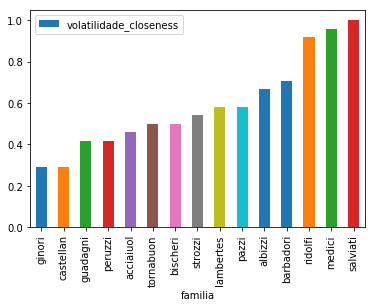

In [88]:
v_closeness = volatilidade.sort_values(by='volatilidade_closeness').plot(kind = 'bar', x='familia', y='volatilidade_closeness')

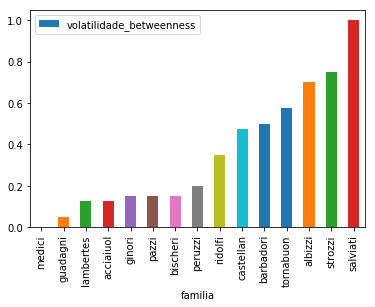

In [89]:
v_bet = volatilidade.sort_values(by='volatilidade_betweenness').plot(kind = 'bar', x='familia', y='volatilidade_betweenness')

In [86]:
def highlight(s):
    if s.pvalue_closeness > 0.05:
        return ['background-color: yellow']*6
    else:
        return ['background-color: white']*6
    
t = t.style.apply(highlight, axis=1)

E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

Um *feedback* da atividade sobre *coreness no Jazz* será dado em breve, para vocês terem uma melhor referência do item 2.

***Resposta***
Após a análise dos resultados obtidos, foi possível corroborar a seguinte hipótese: se modificarmos o tipo de trajetória e considerarmos outros tipos de difusão, os nós com maior closeness simulado e betweenness simulado não serão necessariamente os nós com maior closeness e betweenness segundo as fórmulas clássicas. Essas medidas de centralidade (closeness e betweenness) representam, respecivamente, o quão próximo um nó está dos outros em uma rede, e a quantidade de menores caminhos de todos os vértices para quaisquer outros vértices que passam por aquele nó. Essas medidas são importantes, pois ajudam a definir o quão influente um nó é naquela rede. Sendo assim, considerando o contexto de casamento entre famílias italianas do período Renascentista, pode-se, através desta analise, reconstruir uma parte do cenário político e social da epóca para entender melhor como essas famílias contribuíram no desenvolvimento de acontecimentos históricos entre os séculos XIV e XVII. </br>

Os métodos clássicos para o cálculo de tais medidas envolvem simulações nas quais sempre é adotado um tipo específico de caminho e difusão, utilizando o caminho geodésico e difusão por transferência. Isto implica que a simualção leva em consideração apenas os menores caminhos possíveis e relações onde ocorre transferência de propriedade. No entanto, este cenáro nem sempre representa o comportamento real da rede. Por exemplo, as transferências monetárias que ocorriam entre essas famílias dificilmente seguiriam o menor caminho possível, da mesma forma como uma fofoca, ao ser contada, não implica na perda desta informção pela pessoa que a contou. Portanto, considerar outros tipos de caminho e de difusão poderiam alterar significativamente a percepção de poder e influência nessas famílias. </br>

Para verificar tal hipótese, foi proposta a realização de uma série de testes T, a fim de comparar amostras aleatórias que se valiam de uma permutação entre outros tipos de caminho (caminho, passeio e trilha) e difusão (transferência ou duplicação) com o benchmark dos métodos clássicos. Estes testes T nos permitem obter um p-valor, que indica a probabilidade de obter um valor da estatística de teste como o observado. Ou seja, um p-valor muito pequeno indica que é muito improvável que o resultado de cada simulação seja igual ao do benchmark. Tipicamente, assume-se uma margem de tolerância de 5%, assim, um p-valor menor que 0.05 nos permite reijeitar a hipótese nula com relativa segurança. </br>

Na tabela abaixo, estão os p-values para todos os testes realizados com as médias de closeness e betweenness para cada tipo de caminho e difusão em relação ao benchamark. Ao longo da análise, as medidas de centralidade foram analisadas de forma independente. 

In [87]:
t

Em amarelo, estão os testes em que o p-value é maior que 5%, sendo assim, são os únicos em que não podemos afirmar que houve mudança significativa.

Ao ordenar as famílias pelas medidas de centralidade de forma crescente, observou-se que a hierarquia mudava consistemente para os testes nos quais rejeitamos a hipótese nula. Para facilitar a visualização destas mudanças na posição, foi um criado um parâmetro chamado de volatilidade. Esta medida indica o quão propensa uma família esta a mudar de posição nas simulações ao alterar seus parâmetros. Desta forma, uma volatilidade 0 indica que a família permanceu na mesma posição na hierarquia para todos os testes em comparação ao benchmark; enquanto que uma volatilidade 1 indica a família que mais mudou de posição, sendo a mudança tanto para o topo quanto para a base da hierarquia.

Caso queira visualizar o ranking absoluto das famílias para cada teste, basta subir até a sessão de **RANKING POR CLOSENESS** e **RANKING POR BETWEENNESS** ou [clique aqui](#r)

***Tabela de volatilidade para closeness***

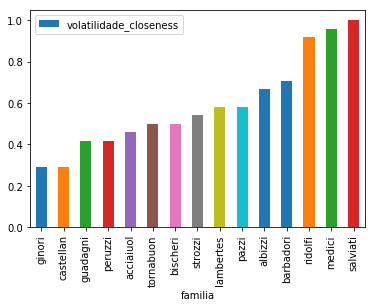

In [97]:
volatilidade.sort_values(by='volatilidade_closeness').plot(kind = 'bar', x='familia', y='volatilidade_closeness')

***Tabela de volatilidade para betweenness***

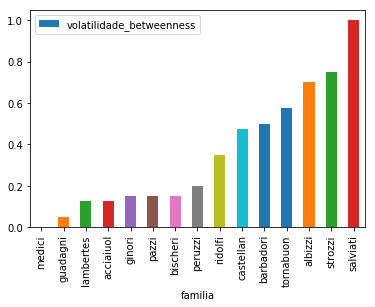

In [98]:
volatilidade.sort_values(by='volatilidade_betweenness').plot(kind = 'bar', x='familia', y='volatilidade_betweenness')

Por fim, foi possível observar que algumas famílias mudam drasticamente de posição na hierarquia quando consideradas outras formas de simulação. Podemos, agora, definir com mais segurança a verdadeira influência destas famílias, por exemplo, uma família que apresentou uma volatilidade baixa, provavelmente está naquela posição real da hierarquia, enquanto que uma muito volátil pode ser menos ou mais influente do que se esperaria baseando-se nos testes clássicos.